<a href="https://colab.research.google.com/github/AshTheFallen/Irish-energy/blob/main/Irish_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
from google.colab import drive
from google.colab import files

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/irish_grid_daily_modified.csv', delimiter = ',')
df.head()

,Unnamed: 0,id,0
0,0,1000,11.203
1,1,1000,8.403
2,2,1000,7.225
3,3,1000,11.338
4,4,1000,11.306


In [ ]:
# aggregate to daily

columns = [str(i) for i in range(0,24)]
df['day'] = df[columns].sum(axis = 1)
df.drop(columns = [str(i) for i in range(0,24)],inplace = True)
print(df.head())
df.to_csv('/content/gdrive/MyDrive/datasets/daily-electricity-usage/irish_daily.csv')

     id        date     day
0  1000  2009-07-15  11.203
1  1000  2009-07-16   8.403
2  1000  2009-07-17   7.225
3  1000  2009-07-18  11.338
4  1000  2009-07-19  11.306


(536, 1)


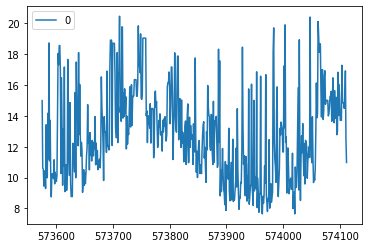

In [6]:
user = df.loc[df.id == 2121].copy()
user.drop(columns = ['Unnamed: 0','id'],inplace = True)
# print(user.shape)
# user = user.stack()
print(user.shape)
user.plot(kind='line')

In [7]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [8]:
# fix random seed for reproducibility
np.random.seed(7)

In [9]:
dataset = user.values.astype('float32')

In [10]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = dataset.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

In [11]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

428 108


In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [13]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [18]:
# create and fit the LSTM network
batch_size = 1
model = Sequential()
# model.add(LSTM(7, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(LSTM(7, batch_input_shape=(batch_size, look_back, 1), stateful=True))
# model.add(LSTM(7,  input_shape =(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
# model.fit(trainX, trainY, epochs=200, batch_size=batch_size, verbose=2, shuffle=False)
for i in range(80):
	model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
	# model.reset_states()

424/424 - 3s - loss: 0.0399
424/424 - 1s - loss: 0.0361
424/424 - 1s - loss: 0.0354
424/424 - 1s - loss: 0.0350
424/424 - 1s - loss: 0.0347
424/424 - 1s - loss: 0.0345
424/424 - 1s - loss: 0.0343
424/424 - 1s - loss: 0.0341
424/424 - 1s - loss: 0.0340
424/424 - 1s - loss: 0.0339
424/424 - 1s - loss: 0.0338
424/424 - 1s - loss: 0.0337
424/424 - 1s - loss: 0.0337
424/424 - 1s - loss: 0.0336
424/424 - 1s - loss: 0.0336
424/424 - 1s - loss: 0.0335
424/424 - 1s - loss: 0.0335
424/424 - 1s - loss: 0.0335
424/424 - 1s - loss: 0.0335
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0334
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss: 0.0333
424/424 - 1s - loss:

Train Score: 0.19 RMSE
Test Score: 0.19 RMSE


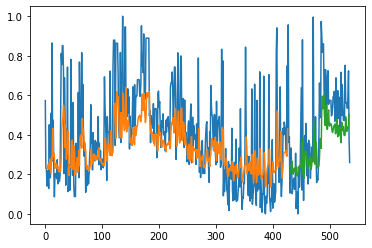

In [20]:
# make predictions
# trainPredict = model.predict(trainX)
trainPredict = model.predict(trainX, batch_size=batch_size)
model.reset_states()
# testPredict = model.predict(testX)
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()